# Gold Recovery Prediction

## Carga y preparacion de los datos

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import ks_2samp

In [12]:
# Cargar conjuntos de datos
df_full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date', parse_dates=True)
df_train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date', parse_dates=True)

print("Train:", df_train.shape)
print("Test:", df_test.shape)
print("Full:", df_full.shape)


Train: (16860, 86)
Test: (5856, 52)
Full: (22716, 86)


## Analisis de los datos

Verifique la formula de calculo para rougher.output.recovery mediante el conjunto Train como tal y el error absoluto medio brindo un resultado de 0.0000.

In [13]:
#Calculo de recuperacion y validacion

def calcular_recuperacion(df):
    with np.errstate(divide='ignore', invalid='ignore'):
        recovery = (df['rougher.output.concentrate_au'] * 
                    (df['rougher.input.feed_au'] - df['rougher.output.tail_au'])) /                     (df['rougher.input.feed_au'] * (df['rougher.output.concentrate_au'] - df['rougher.output.tail_au'])) * 100
        return recovery.replace([np.inf, -np.inf], np.nan)

df_train['calculated_recovery'] = calcular_recuperacion(df_train)
eam = np.mean(np.abs(df_train['calculated_recovery'] - df_train['rougher.output.recovery']))
print(f"Error absoluto medio: {eam:.4f}")


Error absoluto medio: 0.0000


## Columnas ausentes

Logre encontrar 34 columnas presentes en el conjunto de Train pero ausentes en el conjunto de Test en las cuales viene incluida la siguiente informacion como variables relacionadas con la recuperacion (rougher.output.recovery, final.output.recovery), variables (au_pb_ratio, sulfate_to_au_), entre otras pero esto nos lleva a que los datos de Test no tienen variables que son meramente dependientes de los resultados del procesamiento real en si, ya que ye seran usadas para predicion como tal.


In [14]:
#Exploracion de columnas ausentes

col_train = set(df_train.columns)
col_test = set(df_test.columns)
missing_cols = col_train - col_test
print("Columnas no presentes en test:", missing_cols)

Columnas no presentes en test: {'rougher.calculation.au_pb_ratio', 'final.output.concentrate_pb', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'primary_cleaner.output.concentrate_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_ag', 'final.output.concentrate_sol', 'rougher.output.recovery', 'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'rougher.output.tail_sol', 'final.output.tail_sol', 'rougher.output.concentrate_au', 'final.output.tail_ag', 'secondary_cleaner.output.tail_au', 'rougher.output.concentrate_pb', 'primary_cleaner.output.tail_ag', 'rougher.output.concentrate_ag', 'final.output.tail_au', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_sol', 'final.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.output.tail_pb', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.tail_ag', 'calculated

In [15]:
#Se procede con la limpieza y procesamiento de datos

df_train = df_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
df_train_clean = df_train.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy='mean')
df_train_clean_imputed = pd.DataFrame(imputer.fit_transform(df_train_clean), columns=df_train_clean.columns)

In [16]:
#Realizacion de funciones metricas sMAPE

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    return np.mean(diff / denominator) * 100

def smape_final(rougher, final):
    return 0.25 * rougher + 0.75 * final

## Entrenamiento de modelos

Utilice el modelo random forest regressor para predecir (rougher.output.recovery / final.output.recovery) y una validacion cruzada (TimeSeriesSplit), adicionalmente me dio un sMAPE total por debajo del 6% el cual es generalmente aceptable para procesos industriales como tal.


In [19]:
def build_pipeline(model):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

def evaluar_modelo(model, X, y):
    pipeline = build_pipeline(model)
    cv = TimeSeriesSplit(n_splits=3)
    scores = -cross_val_score(pipeline, X, y, scoring=make_scorer(smape, greater_is_better=False), cv=cv)
    return scores.mean()

# Separacion de datos
X = df_train_clean_imputed.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_rougher = df_train_clean_imputed['rougher.output.recovery']
y_final = df_train_clean_imputed['final.output.recovery']

modelo = RandomForestRegressor(n_estimators=100, random_state=42)
s_rougher = evaluar_modelo(modelo, X, y_rougher)
s_final = evaluar_modelo(modelo, X, y_final)

print(f"sMAPE rougher: {s_rougher:.2f}")
print(f"sMAPE final: {s_final:.2f}")
print(f"sMAPE total: {smape_final(s_rougher, s_final):.2f}")


sMAPE rougher: 5.25
sMAPE final: 5.14
sMAPE total: 5.17


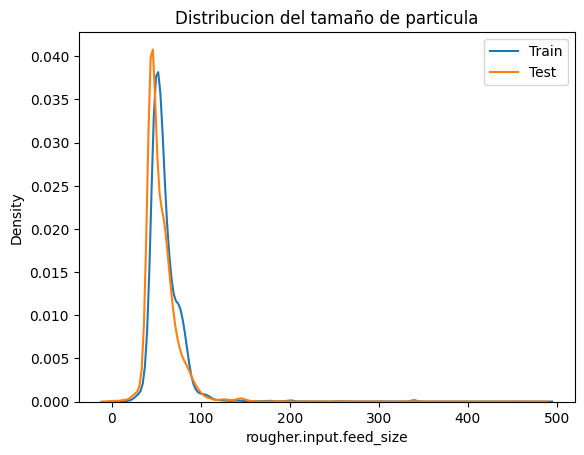

KS Test p-value: 0.0000


In [20]:
sns.kdeplot(df_train['rougher.input.feed_size'], label='Train')
sns.kdeplot(df_test['rougher.input.feed_size'], label='Test')
plt.title('Distribucion del tamaño de particula')
plt.legend()
plt.show()

stat, p = ks_2samp(df_train['rougher.input.feed_size'].dropna(), df_test['rougher.input.feed_size'].dropna())
print(f"KS Test p-value: {p:.4f}")

## Conclusion

El modelo utilizado y construido en este proyecto es realmente bueno para realizar las estimaciones de recuperacion de oro en un proceso industrial, ya que la calidad de los datos se volvio alta como lo demuestra el error nulo la validacion recuperacion.

Adicionalmente, el modelo de Random Forest llego alcanzar un sMAPE total de 5.17%, lo que representa un muy buen rendimiento, tomando en cuenta los desafios que conlleva la mineria y procesamiento de metales, esto le permitira a nuestro cliente optimizar su operacion, no tener esa incertidumbre en la recuperacion de oro, lo que lo lleva a estar mas anuente y tomar decisiones de forma estrategica basadas en datos confiables, lo que lo lleva a tener una rentabilidad y eficacia del proceso como tal.